In [1]:
import nocd
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import normalize

%matplotlib inline

torch.set_default_tensor_type(torch.cuda.FloatTensor)

# Defining and training the model

Load the dataset
 - `A` (adjacency matrix) is a `scipy.sparse.csr_matrix` of size `[N, N]`
 - `X` (attribute matrix) is a `scipy.sparse.csr_matrix` of size `[N, D]`
 - `Z_gt` (binary community affiliation matrix) is a `np.ndarray` of size `[N, K]`

In [2]:
loader = nocd.data.load_dataset('data/mag_cs.npz')
A, X, Z_gt = loader['A'], loader['X'], loader['Z']
N, K = Z_gt.shape

Define the hyperparameters

In [3]:
hidden_sizes = [128]    # hidden sizes of the GNN
weight_decay = 1e-2     # strength of L2 regularization on GNN weights
dropout = 0.5           # whether to use dropout
batch_norm = True       # whether to use batch norm
lr = 1e-3               # learning rate
max_epochs = 500        # number of epochs to train
display_step = 25       # how often to compute validation loss
balance_loss = True     # whether to use balanced loss
stochastic_loss = True  # whether to use stochastic or full-batch training
batch_size = 20000      # batch size (only for stochastic training)

Select & normalize the feature matrix

For some datasets where the features are very informative / correlated with the community structure it's better to use `X` as input (e.g. co-authorship networks w/ keywords as node features). Otherwise, you should try using `A` or `[A, X]` as input.

In [4]:
x_norm = normalize(X)  # node features
# x_norm = normalize(A)  # adjacency matrix
# x_norm = sp.hstack([normalize(X), normalize(A)])  # concatenate A and X
x_norm = nocd.utils.to_sparse_tensor(x_norm).cuda()

Define the GNN model

In [5]:
sampler = nocd.sampler.get_edge_sampler(A, batch_size, batch_size, num_workers=5)
gnn = nocd.nn.GCN(x_norm.shape[1], hidden_sizes, K, batch_norm=batch_norm, dropout=dropout).cuda()
adj_norm = gnn.normalize_adj(A)
decoder = nocd.nn.BerpoDecoder(N, A.nnz, balance_loss=balance_loss)
opt = torch.optim.Adam(gnn.parameters(), lr=lr)

In [6]:
def get_nmi(thresh=0.5):
    """Compute Overlapping NMI of the communities predicted by the GNN."""
    gnn.eval()
    Z = F.relu(gnn(x_norm, adj_norm))
    Z_pred = Z.cpu().detach().numpy() > thresh
    nmi = nocd.metrics.overlapping_nmi(Z_pred, Z_gt)
    return nmi

Training loop

In [7]:
val_loss = np.inf
validation_fn = lambda: val_loss
early_stopping = nocd.train.NoImprovementStopping(validation_fn, patience=10)
model_saver = nocd.train.ModelSaver(gnn)

for epoch, batch in enumerate(sampler):
    if epoch > max_epochs:
        break
    if epoch % 25 == 0:
        with torch.no_grad():
            gnn.eval()
            # Compute validation loss
            Z = F.relu(gnn(x_norm, adj_norm))
            val_loss = decoder.loss_full(Z, A)
            print(f'Epoch {epoch:4d}, loss.full = {val_loss:.4f}, nmi = {get_nmi():.2f}')
            
            # Check if it's time for early stopping / to save the model
            early_stopping.next_step()
            if early_stopping.should_save():
                model_saver.save()
            if early_stopping.should_stop():
                print(f'Breaking due to early stopping at epoch {epoch}')
                break
            
    # Training step
    gnn.train()
    opt.zero_grad()
    Z = F.relu(gnn(x_norm, adj_norm))
    ones_idx, zeros_idx = batch
    if stochastic_loss:
        loss = decoder.loss_batch(Z, ones_idx, zeros_idx)
    else:
        loss = decoder.loss_full(Z, A)
    loss += nocd.utils.l2_reg_loss(gnn, scale=weight_decay)
    loss.backward()
    opt.step()

Epoch    0, loss.full = 1.0301, nmi = 0.03
Epoch   25, loss.full = 0.2925, nmi = 0.34
Epoch   50, loss.full = 0.2478, nmi = 0.42
Epoch   75, loss.full = 0.2237, nmi = 0.44
Epoch  100, loss.full = 0.2137, nmi = 0.47
Epoch  125, loss.full = 0.1989, nmi = 0.46
Epoch  150, loss.full = 0.1946, nmi = 0.48
Epoch  175, loss.full = 0.1899, nmi = 0.49
Epoch  200, loss.full = 0.1988, nmi = 0.48
Epoch  225, loss.full = 0.1899, nmi = 0.50
Epoch  250, loss.full = 0.1944, nmi = 0.48
Epoch  275, loss.full = 0.1897, nmi = 0.49
Epoch  300, loss.full = 0.1852, nmi = 0.49
Epoch  325, loss.full = 0.1899, nmi = 0.52
Epoch  350, loss.full = 0.1885, nmi = 0.49
Epoch  375, loss.full = 0.1893, nmi = 0.48
Epoch  400, loss.full = 0.1842, nmi = 0.50
Epoch  425, loss.full = 0.1890, nmi = 0.49
Epoch  450, loss.full = 0.1873, nmi = 0.49
Epoch  475, loss.full = 0.1879, nmi = 0.49
Epoch  500, loss.full = 0.1828, nmi = 0.50


Depending on whether you use balanced loss or not, you should (probably) use different threshold values. From my experience, following are reasonable defaults:
 - for `balance_loss = True`: `thresh = 0.5`
 - for `balance_loss = False`: `thresh = 0.01`
 
You can look at the distribution of the non-zero entries of `Z` to decide on a good value for the threshold. 
I guess it makes sense to select a value that lies in the leftmost "valley" of histogram below. 
You can also look at the unsupervised metrics in the next section of this notebook to make an informed choice.

Note that all of these are just speculations based on the behavior that I observed for a handful of datasets, YMMV.

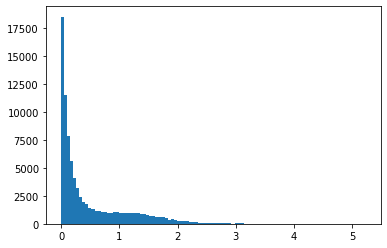

In [8]:
plt.hist(Z[Z > 0].cpu().detach().numpy(), 100);

In [11]:
thresh = 0.5

Z = F.relu(gnn(x_norm, adj_norm))
Z_pred = Z.cpu().detach().numpy() > thresh
model_saver.restore()
print(f'Final nmi = {get_nmi(thresh):.3f}')

Final nmi = 0.498


# Analyzing the results

### Visualize the adjacency matrix sorted by the communities

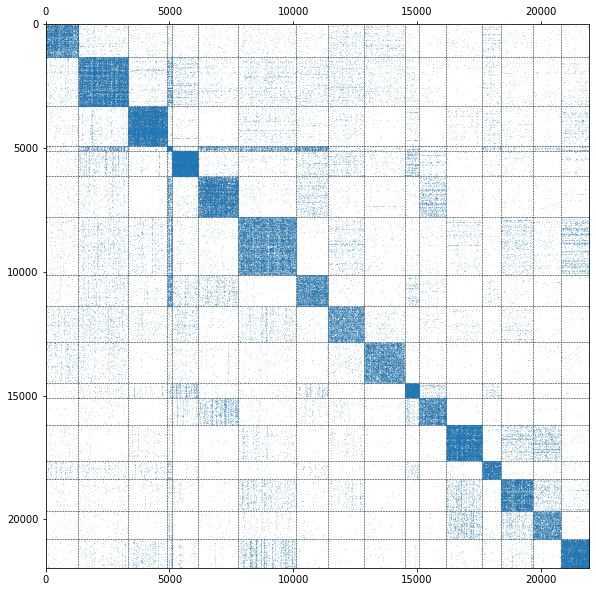

In [12]:
plt.figure(figsize=[10, 10])
z = np.argmax(Z_pred, 1)
o = np.argsort(z)
nocd.utils.plot_sparse_clustered_adjacency(A, K, z, o, markersize=0.05)

In [13]:
# Sizes of detected communities
print(Z_pred.sum(0))

[1047 2023 1618  520 1127 1703 2561 1884 2056 1959  883 1750 1546    0
  970 1853 2071 1591]


### Quantify quality of the communities based on unsupervised metrics.

Metrics:
* **Coverage**: what percentage of the edges is explained by at least one community? (i.e. if $(u, v)$ is an edge, both nodes share at least one community) Higher is better.
$$\textrm{Coverage}(C_1, ..., C_K) = \frac{1}{|E|}\sum_{u, v \in E} \mathbb{1}[z_u^T z_v > 0]$$


* **Density**: average density of the detected communities (weighted by community size). Higher is better.

$$\rho(C) = \frac{\text{# existing edges in $C$}}{\text{# of possible edges in $C$}}$$

$$\textrm{AvgDensity}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \rho(C_i) \cdot |C_i|$$


* **Conductance**: average conductance of the detected communities (weighted by community size). Lower is better.

$$\textrm{outside}(C) = \sum_{u \in C, v \notin C} A_{uv}$$

$$\textrm{inside}(C) = \sum_{u \in C, v \in C, v \ne u} A_{uv}$$

$$\textrm{Conductance}(C) = \frac{\textrm{outside}(C)}{\textrm{inside}(C) + \textrm{outside}(C)}$$

$$\textrm{AvgConductance}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{Conductance}(C_i) \cdot |C_i|$$


* **Clustering coefficient**: average clustering coefficient of the detected communities (weighted by community size). Higher is better.

$$\textrm{ClustCoef}(C) = \frac{\text{# existing triangles in $C$}}{\text{# of possible triangles in $C$}}$$

$$\textrm{AvgClustCoef}(C_1, ..., C_K) = \frac{1}{\sum_i |C_i|}\sum_i \textrm{ClustCoef}(C_i) \cdot |C_i|$$

Clustering coefficient & density of the entire graph

In [14]:
density_baseline = A.nnz / (N**2 - N)
num_triangles = (A @ A @ A).diagonal().sum() / 6
num_possible_triangles = (N - 2) * (N - 1) * N / 6
clust_coef_baseline = num_triangles / num_possible_triangles
print(f'Background (over the entire graph):\n'
      f' - density    = {density_baseline:.3e}\n'
      f' - clust_coef = {clust_coef_baseline:.3e}')

Background (over the entire graph):
 - density    = 4.014e-04
 - clust_coef = 5.733e-08


In [15]:
metrics = nocd.metrics.evaluate_unsupervised(Z_gt, A)
print(f"Ground truth communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Ground truth communities:
 - coverage    = 0.9588
 - conductance = 0.3392
 - density     = 3.853e-03
 - clust_coef  = 9.145e-06


In [16]:
metrics = nocd.metrics.evaluate_unsupervised(Z_pred, A)
print(f"Predicted communities:\n"
      f" - coverage    = {metrics['coverage']:.4f}\n"
      f" - conductance = {metrics['conductance']:.4f}\n"
      f" - density     = {metrics['density']:.3e}\n"
      f" - clust_coef  = {metrics['clustering_coef']:.3e}")

Predicted communities:
 - coverage    = 0.9297
 - conductance = 0.2347
 - density     = 4.861e-03
 - clust_coef  = 1.164e-05


The detected partition has lower conductance / higher density / higher clustering coefficient than the GT communities.